In [1]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
import harmonypy as hm
import scrublet as scr
from matplotlib import rcParams

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120, color_map='viridis')
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.1.0
cffi                1.14.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                2.10.0
harmonypy           NA
igraph              0.7.1
importlib_metadata  1.5.0
ipykernel           5.1.4
ipython_genutils    0.2.0
jedi                0.16.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.8.2
llvmlite            0.34.0
matplotlib          3.2.1
mkl                 2.3.0
mpl_toolkits        NA
natsort             7.1.1
numba               0.51.2
numexpr             2.7.2
numpy               1.19.2
packaging           20.9
pandas              1.1.5
parso               0.6.2
pexpect             4.8.

In [2]:
def DEG_table(adata):
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    markers = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
    return markers

In [3]:
def filtered_DEGs(adata, q_value = 1E-5, fold_change = 1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] >= fold_change)].loc[:,(i+'_n'):(i+'_l')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [4]:
def filtered_DEG_names(adata, q_value = 1E-5, fold_change = 1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] >= fold_change)].loc[:,(i+'_n')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [5]:
def filtered_down_reg_DEGs(adata, q_value = 1E-5, fold_change = -1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] <= fold_change)].loc[:,(i+'_n'):(i+'_l')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [6]:
def filtered_down_reg_DEG_names(adata, q_value = 1E-5, fold_change = -1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] <= fold_change)].loc[:,(i+'_n')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [7]:
adata_orig = sc.read_h5ad('./CMs_zfish_ven_RAW.h5ad')


In [8]:
adata_orig

AnnData object with n_obs × n_vars = 4009 × 25107
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample', 'batch', 'leiden_01', 'leiden_011', 'leiden_012', 'leiden_013', 'leiden_014', 'leiden_015', 'leiden_016', 'leiden_017', 'leiden_018', 'leiden_019', 'leiden_02', 'leiden_021', 'leiden_022', 'leiden_023', 'leiden_024', 'leiden_025', 'leiden_026', 'leiden_027', 'leiden_028', 'leiden_029', 'leiden_03', 'leiden_031', 'leiden_032', 'leiden_033', 'leiden_034', 'leiden_035', 'leiden_036', 'leiden_037', 'leiden_038', 'leiden_039', 'leiden', 'leiden_annotation', 'cell_type'
    var: 'gene_ids', 'feature_types'
    obsm: 'X_pca', 'X_umap'

In [9]:
adata = adata_orig.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy()

In [10]:
adata

AnnData object with n_obs × n_vars = 4009 × 25107
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample', 'batch', 'leiden_01', 'leiden_011', 'leiden_012', 'leiden_013', 'leiden_014', 'leiden_015', 'leiden_016', 'leiden_017', 'leiden_018', 'leiden_019', 'leiden_02', 'leiden_021', 'leiden_022', 'leiden_023', 'leiden_024', 'leiden_025', 'leiden_026', 'leiden_027', 'leiden_028', 'leiden_029', 'leiden_03', 'leiden_031', 'leiden_032', 'leiden_033', 'leiden_034', 'leiden_035', 'leiden_036', 'leiden_037', 'leiden_038', 'leiden_039', 'leiden', 'leiden_annotation', 'cell_type'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap'

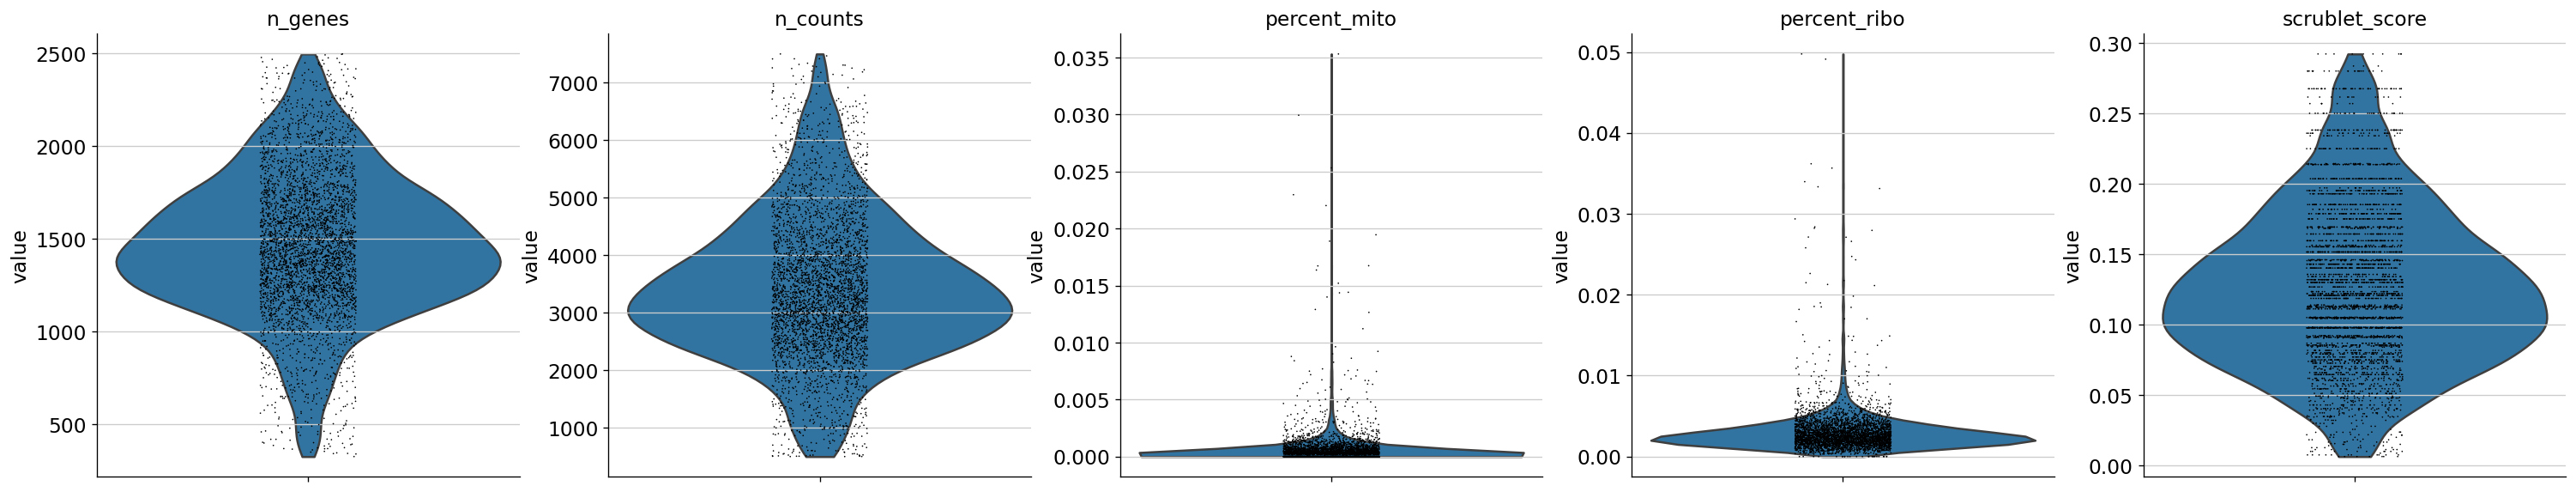

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito','percent_ribo', 'scrublet_score'],
             jitter=0.1, multi_panel=True)

In [12]:
sc.pp.highly_variable_genes(adata, flavor = 'seurat')
adata_hvg = adata[:, adata.var['highly_variable']]

In [13]:
sc.pp.scale(adata_hvg, max_value =10)

/rds/general/user/lb616/home/anaconda3/envs/scanpy2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
sc.tl.pca(adata_hvg, svd_solver='arpack', random_state = 1786)

In [15]:
# Here we do batch correction using harmony, it modifies the PCA space. 
# If you don't have any batches to correct for then this is not necessary. eg. sequence multiple regions from a single heart, you wouldn't want to batch correct as you would lose regional differences
# Here I use the .obs field 'Sample' as the batch groups to correct for.

pca = adata_hvg.obsm['X_pca']
batch = adata_hvg.obs['Sample']
meta_data = adata_hvg.obs

ho = hm.run_harmony(pca, meta_data, ['Sample'
                                    ], random_state=1718, epsilon_harmony = -float('Inf'), max_iter_kmeans = 10, tau=5)

res = pd.DataFrame(ho.Z_corr)
res=res.T
adata_hvg.obsm['X_pca'] = res.values

2021-04-14 15:38:21,323 - harmonypy - INFO - Iteration 1 of 10
2021-04-14 15:38:22,288 - harmonypy - INFO - Iteration 2 of 10
2021-04-14 15:38:23,264 - harmonypy - INFO - Iteration 3 of 10
2021-04-14 15:38:24,229 - harmonypy - INFO - Iteration 4 of 10
2021-04-14 15:38:25,193 - harmonypy - INFO - Iteration 5 of 10
2021-04-14 15:38:26,158 - harmonypy - INFO - Iteration 6 of 10
2021-04-14 15:38:27,125 - harmonypy - INFO - Iteration 7 of 10
2021-04-14 15:38:28,098 - harmonypy - INFO - Iteration 8 of 10
2021-04-14 15:38:29,060 - harmonypy - INFO - Iteration 9 of 10
2021-04-14 15:38:30,024 - harmonypy - INFO - Iteration 10 of 10
2021-04-14 15:38:30,985 - harmonypy - INFO - Stopped before convergence


In [16]:
sc.pp.neighbors(adata_hvg, random_state = 1786)
sc.tl.umap(adata_hvg, min_dist = 0.5, spread = 1, random_state = 1718)

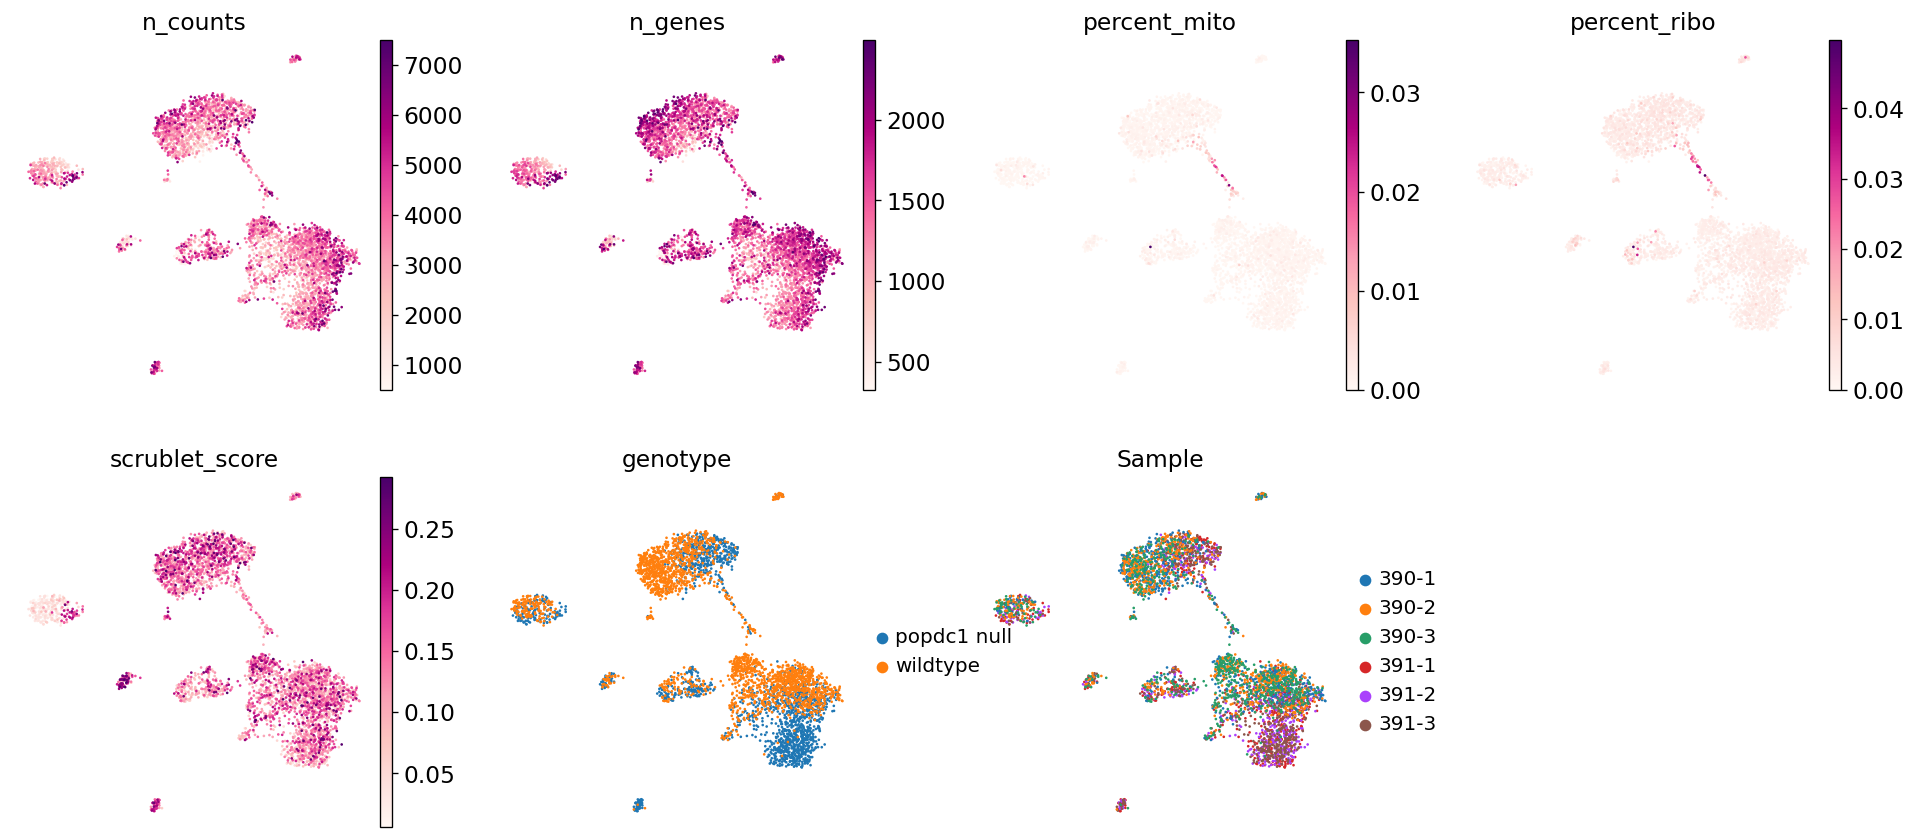

In [17]:
sc.pl.umap(adata_hvg, color = ['n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'scrublet_score', 'genotype', 'Sample'], size = 10, legend_fontsize = 12, frameon = False, color_map='RdPu'
          )

In [18]:
sc.tl.leiden(adata_hvg, resolution = 0.1, random_state = 1786, key_added = 'leiden_01')
sc.tl.leiden(adata_hvg, resolution = 0.11, random_state = 1786, key_added = 'leiden_011')
sc.tl.leiden(adata_hvg, resolution = 0.12, random_state = 1786, key_added = 'leiden_012')
sc.tl.leiden(adata_hvg, resolution = 0.13, random_state = 1786, key_added = 'leiden_013')
sc.tl.leiden(adata_hvg, resolution = 0.14, random_state = 1786, key_added = 'leiden_014')
sc.tl.leiden(adata_hvg, resolution = 0.15, random_state = 1786, key_added = 'leiden_015')
sc.tl.leiden(adata_hvg, resolution = 0.16, random_state = 1786, key_added = 'leiden_016')
sc.tl.leiden(adata_hvg, resolution = 0.17, random_state = 1786, key_added = 'leiden_017')
sc.tl.leiden(adata_hvg, resolution = 0.18, random_state = 1786, key_added = 'leiden_018')
sc.tl.leiden(adata_hvg, resolution = 0.19, random_state = 1786, key_added = 'leiden_019')

sc.tl.leiden(adata_hvg, resolution = 0.2, random_state = 1786, key_added = 'leiden_02')
sc.tl.leiden(adata_hvg, resolution = 0.21, random_state = 1786, key_added = 'leiden_021')
sc.tl.leiden(adata_hvg, resolution = 0.22, random_state = 1786, key_added = 'leiden_022')
sc.tl.leiden(adata_hvg, resolution = 0.23, random_state = 1786, key_added = 'leiden_023')
sc.tl.leiden(adata_hvg, resolution = 0.24, random_state = 1786, key_added = 'leiden_024')
sc.tl.leiden(adata_hvg, resolution = 0.25, random_state = 1786, key_added = 'leiden_025')
sc.tl.leiden(adata_hvg, resolution = 0.26, random_state = 1786, key_added = 'leiden_026')
sc.tl.leiden(adata_hvg, resolution = 0.27, random_state = 1786, key_added = 'leiden_027')
sc.tl.leiden(adata_hvg, resolution = 0.28, random_state = 1786, key_added = 'leiden_028')
sc.tl.leiden(adata_hvg, resolution = 0.29, random_state = 1786, key_added = 'leiden_029')

sc.tl.leiden(adata_hvg, resolution = 0.3, random_state = 1786, key_added = 'leiden_03')
sc.tl.leiden(adata_hvg, resolution = 0.31, random_state = 1786, key_added = 'leiden_031')
sc.tl.leiden(adata_hvg, resolution = 0.32, random_state = 1786, key_added = 'leiden_032')
sc.tl.leiden(adata_hvg, resolution = 0.33, random_state = 1786, key_added = 'leiden_033')
sc.tl.leiden(adata_hvg, resolution = 0.34, random_state = 1786, key_added = 'leiden_034')
sc.tl.leiden(adata_hvg, resolution = 0.35, random_state = 1786, key_added = 'leiden_035')
sc.tl.leiden(adata_hvg, resolution = 0.36, random_state = 1786, key_added = 'leiden_036')
sc.tl.leiden(adata_hvg, resolution = 0.37, random_state = 1786, key_added = 'leiden_037')
sc.tl.leiden(adata_hvg, resolution = 0.38, random_state = 1786, key_added = 'leiden_038')
sc.tl.leiden(adata_hvg, resolution = 0.39, random_state = 1786, key_added = 'leiden_039')

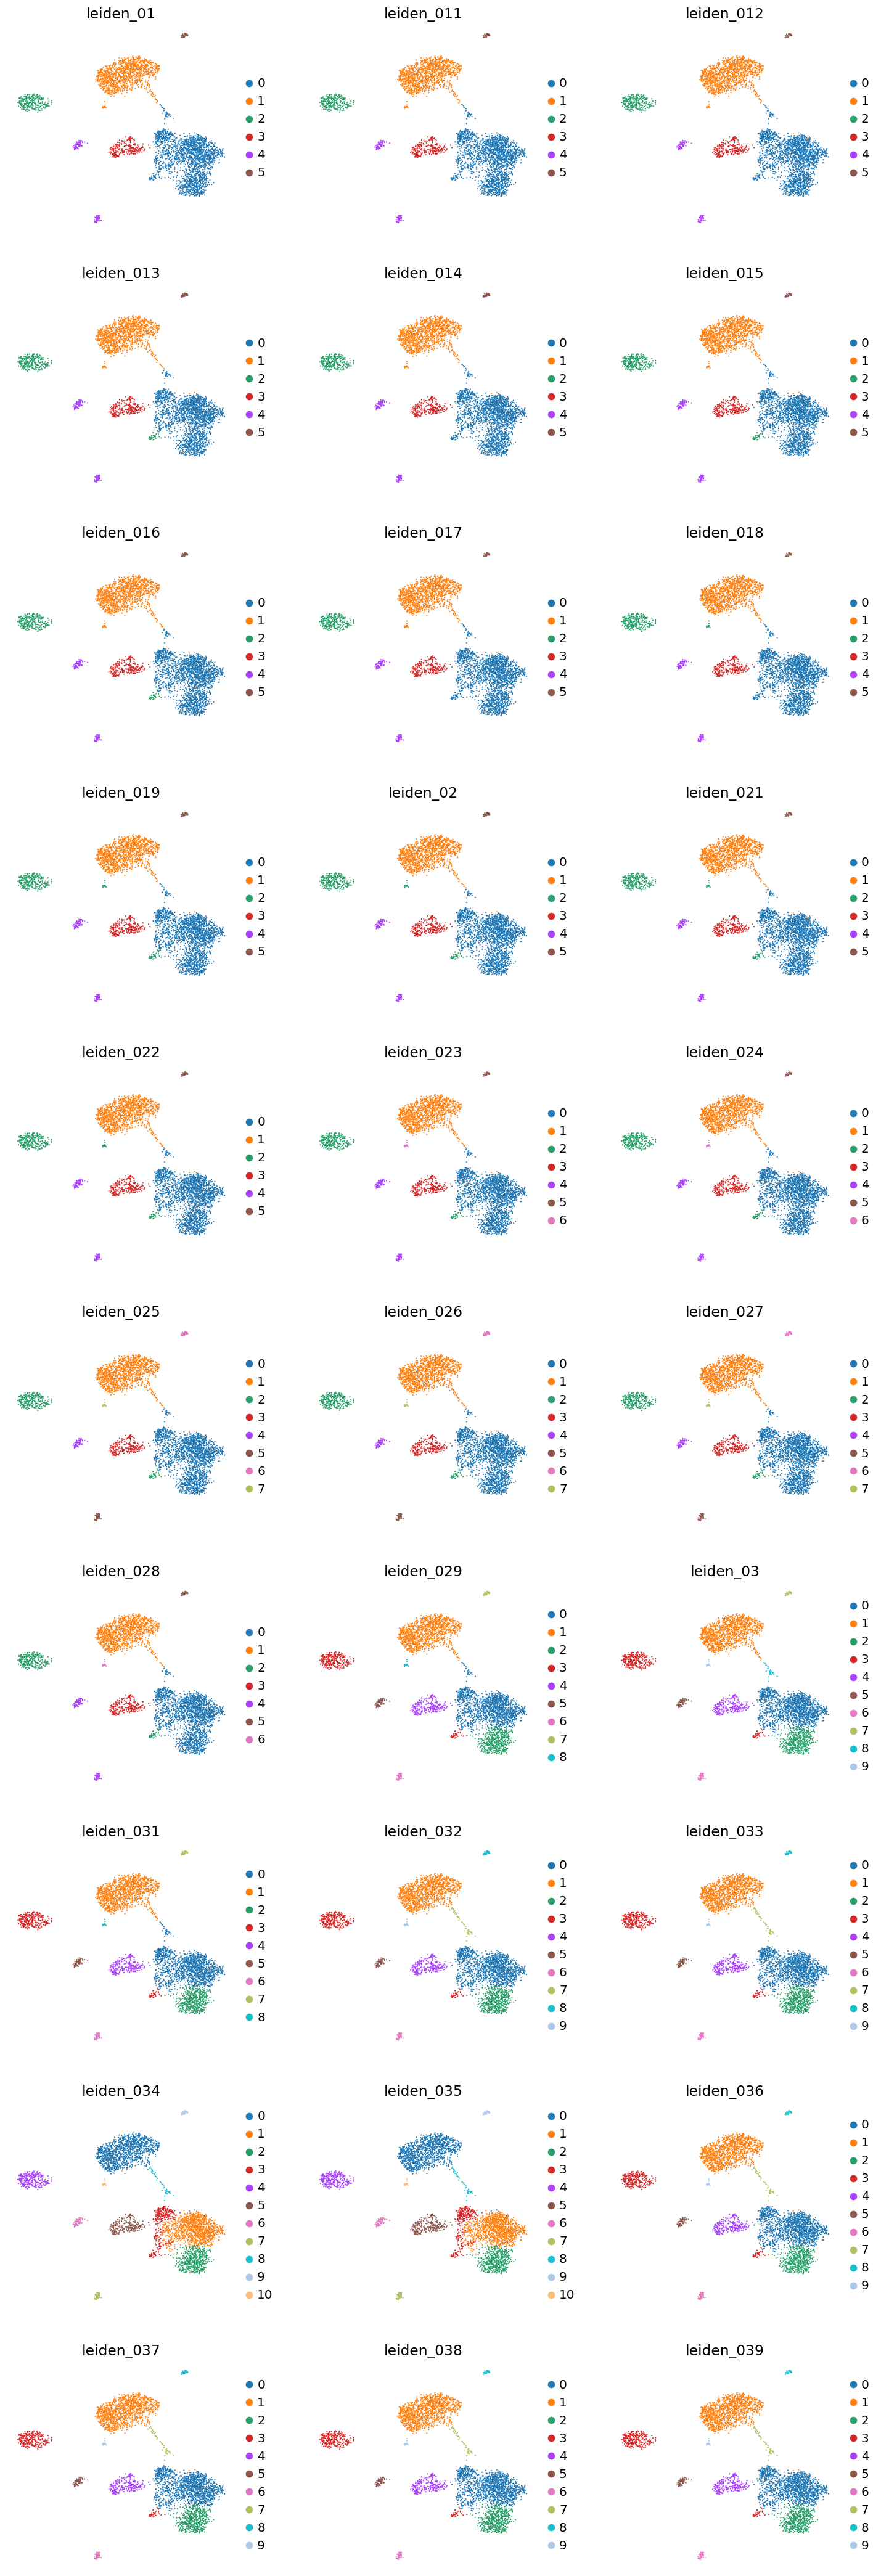

In [19]:
sc.pl.umap(adata_hvg, color = ['leiden_01', 'leiden_011','leiden_012','leiden_013','leiden_014','leiden_015','leiden_016','leiden_017','leiden_018','leiden_019',
                               'leiden_02', 'leiden_021','leiden_022','leiden_023','leiden_024','leiden_025','leiden_026','leiden_027','leiden_028','leiden_029',
                               'leiden_03', 'leiden_031','leiden_032','leiden_033','leiden_034','leiden_035','leiden_036','leiden_037','leiden_038','leiden_039']
           , size = 6, legend_fontsize = 12, frameon = False, ncols=3)

In [20]:
adata_hvg.obs['leiden'] = adata_hvg.obs.leiden_039

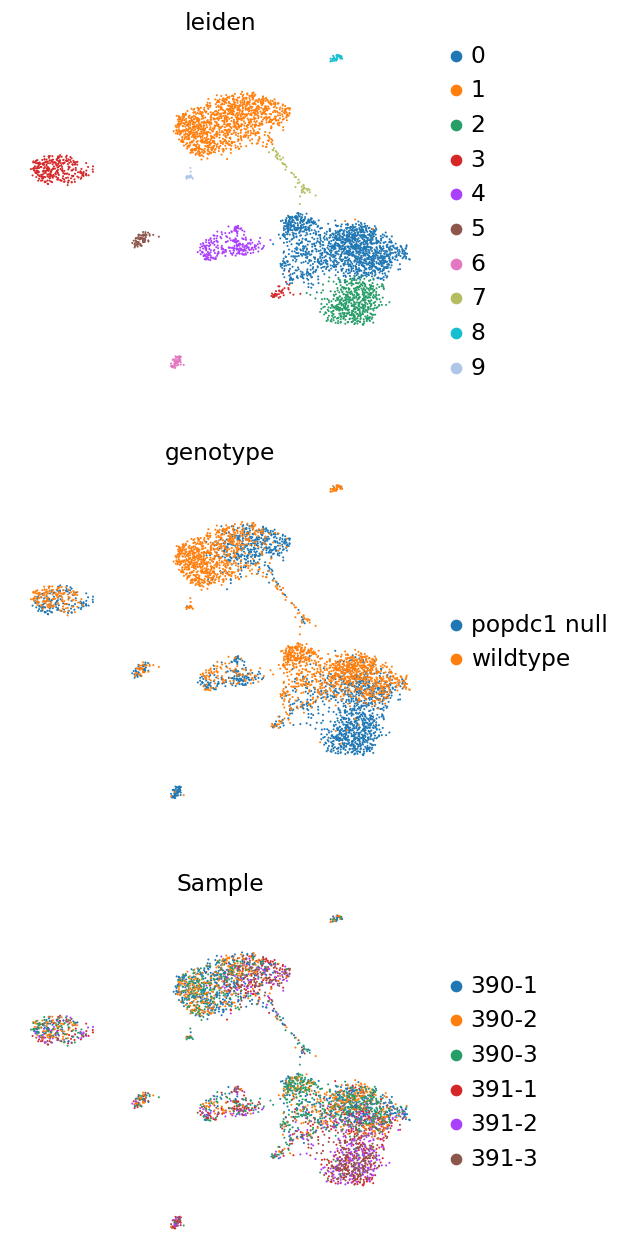

In [22]:
sc.pl.umap(adata_hvg, color = ['leiden', 'genotype', 'Sample', 
                              ], size = 6, legend_fontsize = 14, frameon = False, ncols=1)

In [24]:
# Crosstabs is a handy function for counting how many cells across .obs
pd.crosstab(adata_hvg.obs.genotype, adata_hvg.obs.leiden)

leiden,0,1,2,3,4,5,6,7,8,9
genotype,,,,,,,,,,
popdc1 null,464,404,525,151,155,37,49,16,3,1
wildtype,1010,807,6,170,99,32,3,34,28,15


In [25]:
# Crosstabs is a handy function for counting how many cells across .obs
pd.crosstab(adata_hvg.obs.Sample, adata_hvg.obs.leiden)

leiden,0,1,2,3,4,5,6,7,8,9
Sample,,,,,,,,,,
390-1,307,334,0,37,20,6,0,13,11,5
390-2,318,292,1,66,34,15,1,6,12,3
390-3,385,181,5,67,45,11,2,15,5,7
391-1,183,123,162,58,59,8,23,3,1,0
391-2,133,111,182,51,49,7,13,5,1,0
391-3,148,170,181,42,47,22,13,8,1,1


In [26]:
sc.tl.rank_genes_groups(adata_hvg, 'leiden'
                        , method = 'wilcoxon', use_raw = True)

In [27]:
markers_nuclei = DEG_table(adata_hvg)
markers_nuclei.head(10)

,0_n,0_p,0_l,1_n,1_p,1_l,2_n,2_p,2_l,3_n,...,6_l,7_n,7_p,7_l,8_n,8_p,8_l,9_n,9_p,9_l
0,nhsl1a,9.919214e-214,2.638261,si:dkeyp-23e4.3,0.000000e+00,4.592682,atf3,2.311547e-152,3.806298,tns1b,...,3.634318,slc25a5,1.035182e-23,3.763057,col14a1a,3.424311e-09,6.038272,rorc,1.250345e-07,10.371024
1,scn5lab,1.124508e-209,1.749248,DAB2,5.525835e-300,3.672535,acta1b,2.992402e-144,3.363707,fhod3b,...,3.431167,mt-co3,4.154280e-23,4.530180,agrn,7.564328e-06,1.922941,dapp1,3.336113e-07,14.330014
2,mylk4b,6.146948e-199,2.300118,zfpm2a,1.600126e-185,1.275293,sgsm2,2.676454e-135,3.199016,bcam,...,1.808802,mt-co2,4.374435e-22,4.591269,laptm4b,7.564328e-06,5.100462,si:dkey-242e21.3,3.336113e-07,11.239137
3,kcnj14,1.049231e-169,2.449059,nbeaa,1.083266e-150,1.266844,ssrp1a,8.864278e-127,2.685112,pdlim5a,...,2.497591,mt-co1,6.055693e-20,4.937637,zfpm2a,1.162242e-05,0.898876,runx3,3.336113e-07,10.744874
4,tbx5a,4.544496e-164,3.343153,magi1b,4.997893e-127,2.810396,nppa,2.191531e-126,3.625210,kif26ba,...,1.979189,mt-atp6,4.391610e-18,4.516574,acsbg2,2.005327e-05,3.049368,hdac7b,3.336113e-07,11.404272
5,cacna1g,1.742369e-145,2.172214,sema6e,3.146393e-121,1.119080,slc43a1a,1.716187e-125,2.390479,phlda2,...,2.859519,cmlc1,4.525644e-17,2.455758,cobl,9.274635e-05,2.439862,sox13,3.336113e-07,11.499031
6,angpt1,1.840580e-141,1.423410,gabrb2a,1.499338e-115,3.564668,BX323861.3,1.561948e-116,1.917974,sorbs1,...,2.154836,mt-nd1,1.065290e-16,5.253240,prickle3,9.385687e-05,2.364561,znf385b,3.336113e-07,9.640043
7,efnb3b,9.975835e-133,1.576538,ldb3b,5.909723e-109,1.184091,itga5,8.762421e-112,1.907995,myh10,...,3.099951,mt-cyb,3.110406e-15,4.785516,si:dkeyp-23e4.3,2.931035e-04,2.735090,si:dkey-172j4.3,3.336113e-07,9.011499
8,gcgra,9.702202e-119,1.803507,drp2,1.677520e-102,2.872754,ACTC1,5.136281e-107,3.540364,plekha7a,...,2.401068,rps3a,4.482387e-10,5.042593,nfixa,4.213401e-04,0.988462,ccnd2a,3.336113e-07,5.455871
9,adcy6b,3.740804e-118,1.472146,nlgn3a,2.907240e-92,2.646074,dntt,6.728979e-107,2.478274,daam1b,...,1.561124,gapdh,8.763087e-10,2.433131,drp2,4.864377e-04,2.455742,ptpn4b,6.836441e-06,4.572823


In [28]:
sc.tl.dendrogram(adata_hvg, groupby='leiden')

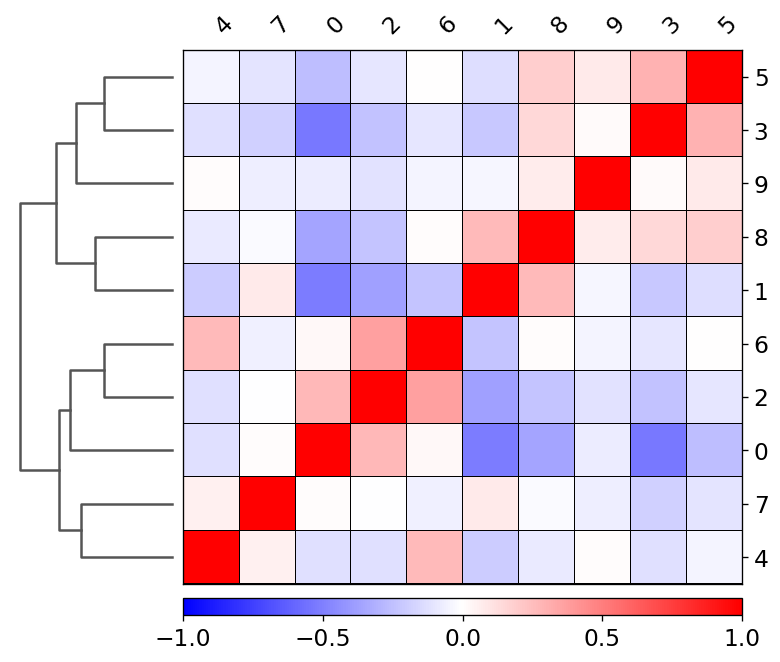

In [29]:
sc.pl.correlation_matrix(adata_hvg, groupby='leiden')

In [33]:
filtered_markers_nuclei = filtered_DEGs(adata_hvg, q_value = 1E-2, fold_change = 1)

In [34]:
filtered_markers_nuclei.head(20)

,0_n,0_p,0_l,1_n,1_p,1_l,2_n,2_p,2_l,3_n,...,6_l,7_n,7_p,7_l,8_n,8_p,8_l,9_n,9_p,9_l
0,nhsl1a,9.919214e-214,2.638261,si:dkeyp-23e4.3,0.000000e+00,4.592682,atf3,2.311547e-152,3.806298,tns1b,...,3.634318,slc25a5,1.035182e-23,3.763057,col14a1a,3.424311e-09,6.038272,rorc,1.250345e-07,10.371024
1,scn5lab,1.124508e-209,1.749248,DAB2,5.525835e-300,3.672535,acta1b,2.992402e-144,3.363707,fhod3b,...,3.431167,mt-co3,4.154280e-23,4.530180,agrn,7.564328e-06,1.922941,dapp1,3.336113e-07,14.330014
2,mylk4b,6.146948e-199,2.300118,zfpm2a,1.600126e-185,1.275293,sgsm2,2.676454e-135,3.199016,bcam,...,1.808802,mt-co2,4.374435e-22,4.591269,laptm4b,7.564328e-06,5.100462,si:dkey-242e21.3,3.336113e-07,11.239137
3,kcnj14,1.049231e-169,2.449059,nbeaa,1.083266e-150,1.266844,ssrp1a,8.864278e-127,2.685112,pdlim5a,...,2.497591,mt-co1,6.055693e-20,4.937637,acsbg2,2.005327e-05,3.049368,runx3,3.336113e-07,10.744874
4,tbx5a,4.544496e-164,3.343153,magi1b,4.997893e-127,2.810396,nppa,2.191531e-126,3.625210,kif26ba,...,1.979189,mt-atp6,4.391610e-18,4.516574,cobl,9.274635e-05,2.439862,hdac7b,3.336113e-07,11.404272
5,cacna1g,1.742369e-145,2.172214,sema6e,3.146393e-121,1.119080,slc43a1a,1.716187e-125,2.390479,phlda2,...,2.859519,cmlc1,4.525644e-17,2.455758,prickle3,9.385687e-05,2.364561,sox13,3.336113e-07,11.499031
6,angpt1,1.840580e-141,1.423410,gabrb2a,1.499338e-115,3.564668,BX323861.3,1.561948e-116,1.917974,sorbs1,...,2.154836,mt-nd1,1.065290e-16,5.253240,si:dkeyp-23e4.3,2.931035e-04,2.735090,znf385b,3.336113e-07,9.640043
7,efnb3b,9.975835e-133,1.576538,ldb3b,5.909723e-109,1.184091,itga5,8.762421e-112,1.907995,myh10,...,3.099951,mt-cyb,3.110406e-15,4.785516,drp2,4.864377e-04,2.455742,si:dkey-172j4.3,3.336113e-07,9.011499
8,gcgra,9.702202e-119,1.803507,drp2,1.677520e-102,2.872754,ACTC1,5.136281e-107,3.540364,plekha7a,...,2.401068,rps3a,4.482387e-10,5.042593,chmp6b,6.415389e-04,4.113723,ccnd2a,3.336113e-07,5.455871
9,adcy6b,3.740804e-118,1.472146,nlgn3a,2.907240e-92,2.646074,dntt,6.728979e-107,2.478274,daam1b,...,1.561124,gapdh,8.763087e-10,2.433131,adamtsl3,7.937300e-04,2.690797,ptpn4b,6.836441e-06,4.572823


In [35]:
filtered_markers_names_nuclei = filtered_DEG_names(adata_hvg, q_value = 1E-2, fold_change = 1)
filtered_markers_names_nuclei.head(20)

,0_n,1_n,2_n,3_n,4_n,5_n,6_n,7_n,8_n,9_n
0,nhsl1a,si:dkeyp-23e4.3,atf3,tns1b,si:ch211-250g4.3,grb10a,si:ch211-250g4.3,slc25a5,col14a1a,rorc
1,scn5lab,DAB2,acta1b,fhod3b,nt5c2l1,spock3,nppa,mt-co3,agrn,dapp1
2,mylk4b,zfpm2a,sgsm2,bcam,hbba1-1,coro1ca,itga5,mt-co2,laptm4b,si:dkey-242e21.3
3,kcnj14,nbeaa,ssrp1a,pdlim5a,ank1a,si:dkey-172h23.2,sgsm2,mt-co1,acsbg2,runx3
4,tbx5a,magi1b,nppa,kif26ba,si:ch211-5k11.8,egfl7,slc43a1a,mt-atp6,cobl,hdac7b
5,cacna1g,sema6e,slc43a1a,phlda2,wnk4b,adam12,atf3,cmlc1,prickle3,sox13
6,angpt1,gabrb2a,BX323861.3,sorbs1,slc20a1a,trpv4,ssrp1a,mt-nd1,si:dkeyp-23e4.3,znf385b
7,efnb3b,ldb3b,itga5,myh10,spns2,CU928117.1,ACTC1,mt-cyb,drp2,si:dkey-172j4.3
8,gcgra,drp2,ACTC1,plekha7a,epb41b,f8,f3b,rps3a,chmp6b,ccnd2a
9,adcy6b,nlgn3a,dntt,daam1b,si:ch211-227m13.1,srgap2,ell,gapdh,adamtsl3,ptpn4b


In [36]:
filtered_markers_nuclei.to_csv('./CMs_zfish_wilcox.csv', sep = ',', index = False)
filtered_markers_names_nuclei.transpose().to_csv('./CMs_zfish_wilcox_names.csv', sep = ',', index = True, header=False)

In [38]:
adata_hvg.obs['leiden'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')

In [39]:
adata_hvg.obs['leiden_annotation'] = adata_hvg.obs['leiden'].copy()

In [40]:
adata_hvg.obs['cell_states'] = adata_hvg.obs['leiden'].astype(str)
old_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
new_names = ['CM1', 'CM2', 'CM3', 'CM4', 'CM5', 'CM6', 'CM7', 'CM8', 'CM9','CM10']
adata_hvg.obs['cell_states'] = adata_hvg.obs['cell_states'].map(dict(zip(old_names, new_names))).astype('category')

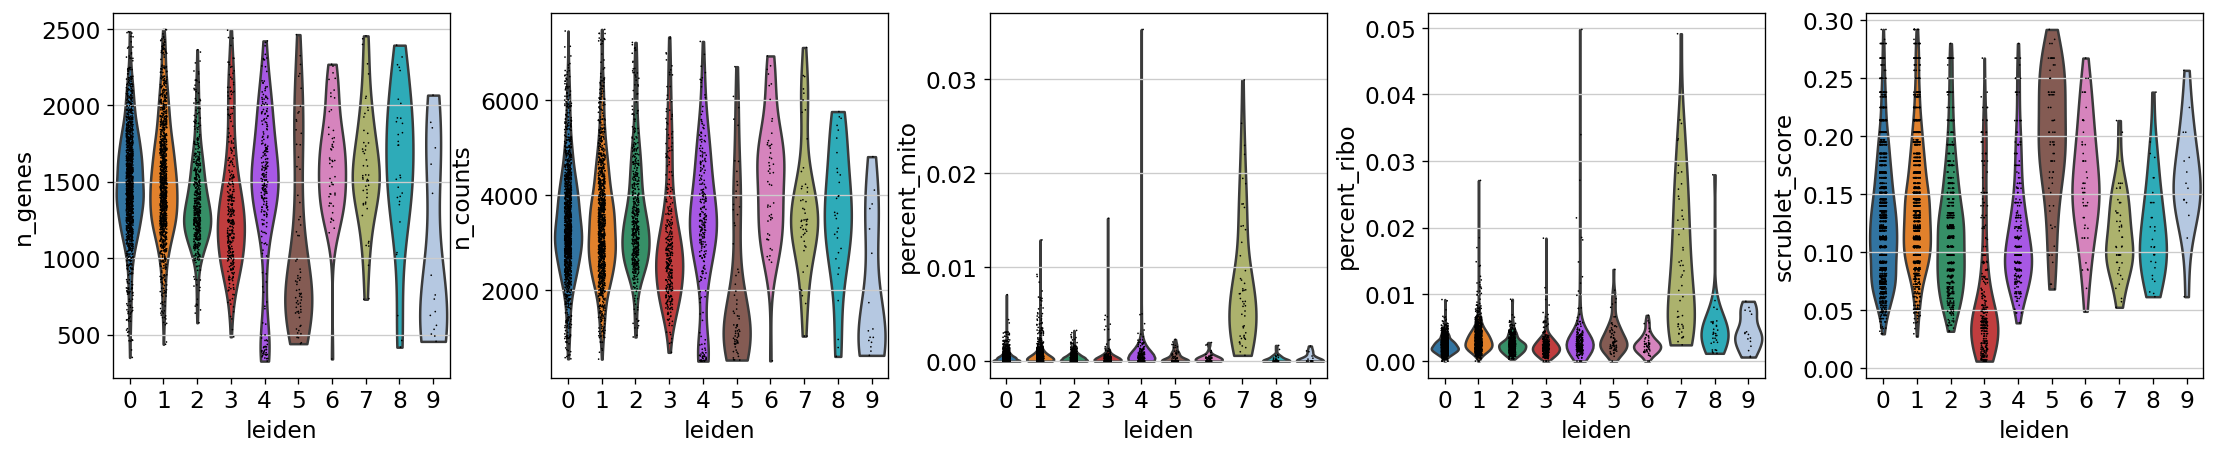

In [41]:
sc.pl.violin(adata_hvg, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score'], groupby='leiden', jitter=0.1, multi_panel=True)

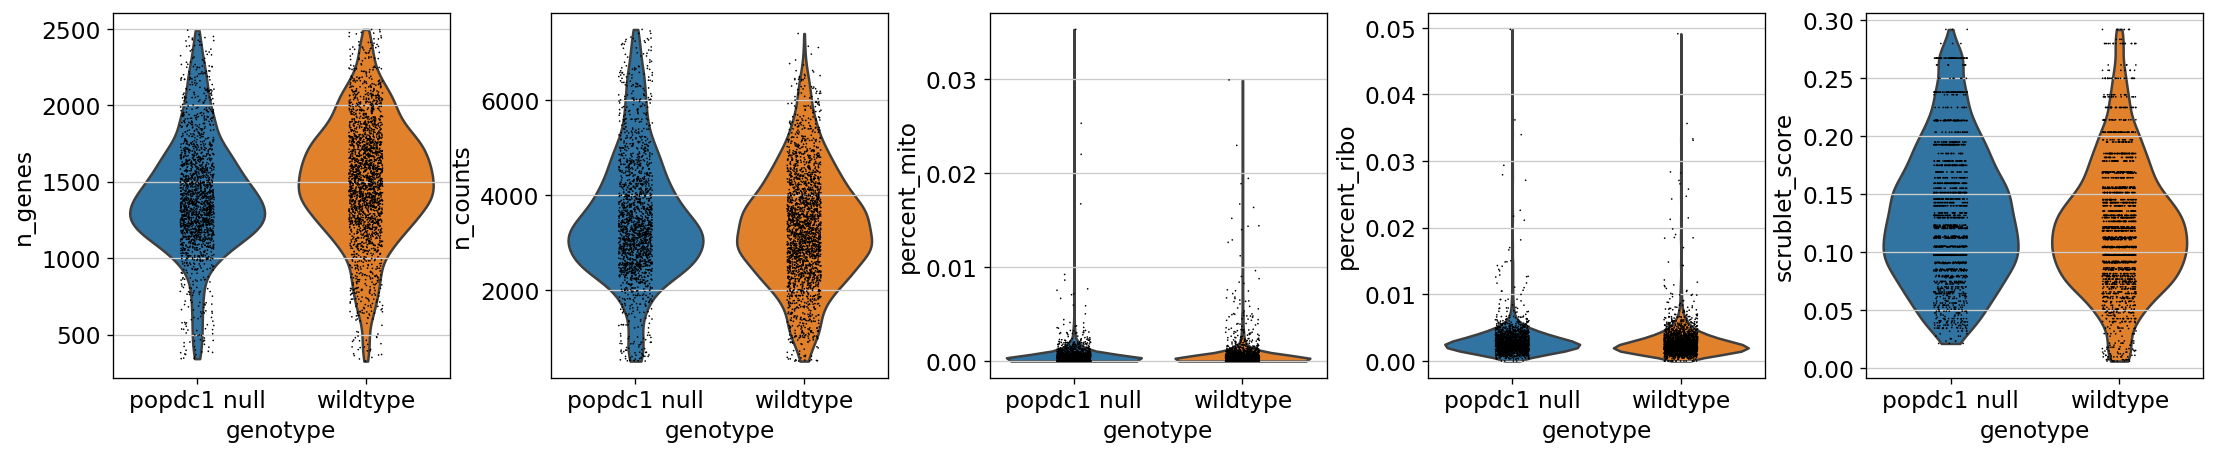

In [42]:
sc.pl.violin(adata_hvg, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score'], groupby='genotype', jitter=0.1, multi_panel=True)

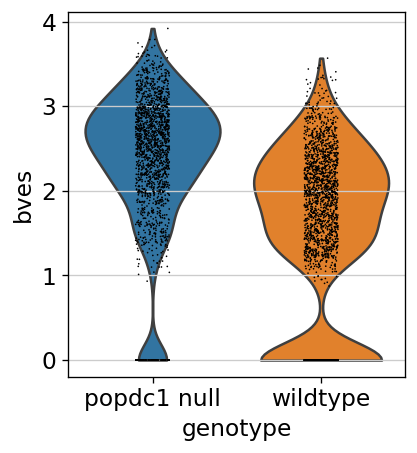

In [43]:
sc.pl.violin(adata_hvg, ['bves'], groupby='genotype', jitter=0.1, multi_panel=True)